In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""flags, file path, and file names for saving data and figures"""

# have data file already?
have_data_file = False  # if True, load data from file
                        # if False, run simulation (and save data)

if have_data_file:
    # load data from this path (including file name)
    data_path = 'YOUR LOCAL DIRECTORY WHERE DATA FILE IS ALREADY SAVED'
else:
    # save simulated data?
    save_data = False
    # file name for new simulated data to be saved
    filename_data = 'data-inverted-gain_yyyy-mm-dd.npz'

# save simulated data and/or figure panel(s) to this path (excluding file name)
save2path = 'YOUR LOCAL DIRECTORY FOR SAVING FILES'

# save figure panel 7g?
save_fig7g = False
# save figure panel 7h?
save_fig7h = False
# figure panel file format, e.g. 'pdf', 'eps', 'svg'
fig_format = 'pdf'
# figure panel file names
filename_fig7g = 'fig7g-inverted-gain_yyyy-mm-dd'
filename_fig7h = 'fig7h-inverted-gain_low-ER-amplitude_yyyy-mm-dd'

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from ra_network import RingAttractorNetwork, \
    back_to_circ, movmean, plot_all, sliding_window, offset_variation, \
        generate_ground_truth, generate_ER_input, generate_AV_input_noise, generate_ER_input_noise

In [4]:
# plotting parameters

mpl.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
    })

%matplotlib inline

In [5]:
# ring attractor network parameters

network_params = {
    'N' : 32,                               # number of neurons
    'tau': 0.05,                            # network time constant [s]
    'alpha': -8.93,                         # self-excitation parameter
    'D' : 5.19,                             # nearest-neighbor excitation
    'beta' : 0.11,                          # global inhibition parameter
    'f_act' : lambda x: np.maximum(0,x+1),  # activation function
    'v_rel' : 3.64 ,                        # angular velocity conversion factor
    'dt' : 0.0025                           # step size [s]
    }

In [6]:
def calc_invert_gain_cue_position(dt, v_AV, z_0):
    """compute cue position during inverted gain learning
    Args:
        dt: (float) simulation step size [s]
        v_AV: (np.ndarray of shape (n_timesteps_invert,)) ground truth angular velocity (AV) [radian/s]
        z_0: (float) initial position between -pi and pi [radian]
    Returns:
        cue_pos_invert: (np.ndarray of shape (n_timesteps_invert,)) cue position [radian]
    """

    # number of time steps during inverted gain learning
    n_timesteps_invert = len(v_AV)

    # initialization
    cue_pos_invert = np.full((n_timesteps_invert), np.nan)
    z_invert = z_0.copy()
    cue_pos_invert[0] = z_invert

    for t in range(1, n_timesteps_invert):
        # update cue position according to inverted gain
        z_invert = back_to_circ(z_invert - v_AV[t] * dt)
        cue_pos_invert[t] = z_invert

    return cue_pos_invert

In [7]:
"""specify simulation parameters"""

n_sims = 100    # number of simulations

# specify array of ER amplitude scales (cue intensities)
ER_amplitude_scale_array = np.arange(1, 2.05, 0.25)
n_params = len(ER_amplitude_scale_array)

# specify gamma decay parameter
gamma_decay = 17

# simulation time parameters
T_burn_in = 60                                              # time interval for activity to stabilize under normal gain [s]
T_gain_normal = 8                                           # length of normal gain [s]
T_gain_invert = 32                                          # length of inverted gain [s]
T = T_gain_normal + T_gain_invert                           # total length of simulation [s]
t_gain_normal_start = T_burn_in                             # time when normal gain learning starts [s]
t_gain_invert_start = t_gain_normal_start + T_gain_normal   # time when inverted gain learning starts [s]

# ER input parameters
ER_baseline_factor = 0.45

# specify initial weight norm
W_norm_init = 1.5

# specify window size for computing offset variability
windowsize_offset_variability = 3200  # [steps], equivalent to 8 [s] in simulation

# specify standard deviation of Gaussian kernel for smoothingx ER->EPG weight matrix
sigma_smooth = 2


"""create ring attractor object"""

ra = RingAttractorNetwork(network_params)
ra.gamma_Hebb = 1
ra.gamma_postboost = 1
ra.gamma_decay = gamma_decay
ra.eta = 5e-5

h0, w0 = ra.determine_features_basic()
ER_baseline = ER_baseline_factor * np.sum(ra.r_init)

n_timesteps = int(T / ra.dt)                                # number of time steps in simulation excluding burn-in
n_timesteps_gain_normal = int(T_gain_normal / ra.dt)        # number of time steps in normal gain
n_timesteps_gain_invert = int(T_gain_invert / ra.dt)        # number of time steps in inverted gain

In [8]:
"""simulation"""

if not have_data_file:
    # generate list of random seeds
    rng_seeds = [random.randrange(2**32-1) for i_sim in range(n_sims)]

    # initialize data arrays for main figure
    offset_variability_array = np.full((n_sims, n_params, n_timesteps), np.nan)
    cue_offset_variability_array = np.full((n_sims, n_params, n_timesteps_gain_invert), np.nan)
    bump_width_array = np.full((n_sims, n_params, n_timesteps), np.nan)
    bump_amplitude_array = np.full((n_sims, n_params, n_timesteps), np.nan)
    W_notch_depth_array = np.full((n_sims, n_params, n_timesteps), np.nan)
    ER_amplitude_array = np.full((n_params), np.nan)

    # initialize data arrays for auxilliary plots
    W_norm_array = np.full((n_sims, n_params, n_timesteps), np.nan)

    for i_sim in tqdm(range(n_sims)):
        ra.reset_network()

        # generate ground truth AV input and HD for learning
        v_AV, z_HD = generate_ground_truth(ra.dt, T_burn_in + T)

        # ground truth HD at the start of inverted gain learning
        z_invert_start = z_HD[int(t_gain_invert_start / ra.dt)]

        # ground truth AV during inverted gain learning, shape (n_timesteps_gain_invert,)
        v_AV_invert = v_AV[int(t_gain_invert_start / ra.dt):]

        # cue position during inverted gain learning, shape (n_timesteps_gain_invert,)
        cue_pos_invert = calc_invert_gain_cue_position(ra.dt, v_AV_invert, z_invert_start)

        # cue position during the entire simulation, excluding burn-in, shape (n_timesteps,)
        cue_pos = np.concatenate((z_HD[int(t_gain_normal_start):int(t_gain_invert_start / ra.dt)], cue_pos_invert), axis=0)

        # generate AV input noise
        noise_AV = generate_AV_input_noise(ra.dt, T_burn_in + T)

        # determine random initialization for weight matrix
        W_init = np.random.uniform(0, 1, (ra.N, ra.N))
        W_init = W_norm_init * W_init / np.linalg.norm(W_init)

        for i_param, ER_amplitude_scale in enumerate(ER_amplitude_scale_array):
            # seed random number generator
            rng_seed = rng_seeds[i_sim]
            np.random.seed(rng_seed)

            # generate ER input
            g_normal, g_invert, ER_amplitude = generate_ER_input(ra, T_burn_in + T, v_AV, z_HD, h_scale=ER_amplitude_scale)
            ER_amplitude_array[i_param] = ER_amplitude

            # concatenate first half of ER input for normal gain learning and second half of ER input for inverted gain learning
            g = np.vstack((g_normal[:int(t_gain_invert_start/ra.dt)], g_invert[-int(T_gain_invert/ra.dt):]))

            # generate ER input noise
            noise_g = generate_ER_input_noise(g)            # generate uniform input noise
            noise_g = noise_g.T / np.sum(noise_g, axis=1)   # normalize by sum, shape (ra.N, int(T/ra.dt))
            noise_g = ER_baseline * noise_g                 # scale by constant ER baseline, independent of ER activity
            noise_g = noise_g.T                             # shape (int(T/ra.dt), ra.N)

            # reset network
            ra.reset_network()

            # initialize weight matrix with random weights
            ra.W = np.copy(W_init)

            # simulate
            ra.simulate(T_burn_in + T, v = v_AV + noise_AV, g = g + noise_g, learn=True, trace=True)

            # extract bump position
            bump_pos = ra.determine_bumpPosition(ydata=ra.r_trace)

            # get ER->EPG weight matrices across time
            W_trace = ra.W_trace.copy()

            # compute weight matrix Frobenius norm
            W_norm_array[i_sim, i_param, :] = np.linalg.norm(ra.W_trace[int(T_burn_in/ra.dt):], axis=(1, 2))

            for tt in range(n_timesteps):
                t = tt + int(T_burn_in/ra.dt)

                # extract bump parameters
                bump_amplitude_array[i_sim, i_param, tt], bump_width_array[i_sim, i_param, tt] = ra.determine_features_basic(ind=t)

                # extract bump position, ground truth HD, and cue position in a sliding window
                window_bump_pos = sliding_window(bump_pos, t, windowsize_offset_variability)    # bump position
                window_z = sliding_window(z_HD, t, windowsize_offset_variability)               # ground truth

                # compute offset variability
                offset_variability_array[i_sim, i_param, tt] = offset_variation(window_bump_pos, window_z)

                if tt >= n_timesteps_gain_normal:
                    window_cue_pos = sliding_window(cue_pos, tt, windowsize_offset_variability)     # cue position
                    cue_offset_variability_array[i_sim, i_param, tt - n_timesteps_gain_normal] = offset_variation(window_bump_pos, window_cue_pos)

                # smooth ER-> EPG weight matrix with Gaussian filter
                W_smoothed = gaussian_filter(W_trace[t], sigma_smooth, mode = 'wrap')

                # compute weight matrix notch depth, i.e. max-min
                W_notch_depth_array[i_sim, i_param, tt] = np.max(W_smoothed) - np.min(W_smoothed)

    # compute HD encoding accuracy from offset variability
    HD_encoding_accuracy_array = 1 - offset_variability_array
    cue_pos_encoding_accuracy_array = 1 - cue_offset_variability_array

100%|██████████| 100/100 [34:56<00:00, 20.97s/it]


In [9]:
"""save data"""

if have_data_file:
    pass
else:
    if save_data:
        np.savez(os.path.join(save2path, filename_data),
            offset_variability_array = offset_variability_array,
            cue_offset_variability_array = cue_offset_variability_array,
            HD_encoding_accuracy_array = HD_encoding_accuracy_array,
            cue_pos_encoding_accuracy_array = cue_pos_encoding_accuracy_array,
            bump_width_array = bump_width_array,
            bump_amplitude_array = bump_amplitude_array,
            W_notch_depth_array = W_notch_depth_array,
            ER_amplitude_array = ER_amplitude_array,
            rng_seeds = rng_seeds
        )

In [10]:
"""load data"""

if have_data_file:
    with np.load(data_path) as data_arrays:
        offset_variability_array = data_arrays['offset_variability_array'],
        HD_encoding_accuracy_array = data_arrays['HD_encoding_accuracy_array'],
        bump_width_array = data_arrays['bump_width_array'],
        bump_amplitude_array = data_arrays['bump_amplitude_array'],
        W_notch_depth_array = data_arrays['W_notch_depth_array'],
        ER_amplitude_array = data_arrays['ER_amplitude_array'],
        rng_seeds = data_arrays['rng_seeds']

    offset_variability_array = offset_variability_array[0]
    HD_encoding_accuracy_array = HD_encoding_accuracy_array[0]
    bump_width_array = bump_width_array[0]
    bump_amplitude_array = bump_amplitude_array[0]
    W_notch_depth_array = W_notch_depth_array[0]
    ER_amplitude_array = ER_amplitude_array[0]

In [11]:
"""normalize HD encoding accuracy by steady-state value during normal gain"""

# compute steady-state offset variability prior to gain inversion
offset_variability_steady_state = np.mean(offset_variability_array[:, :, :n_timesteps_gain_normal], axis=2)

# compute steady-state HD encoding accuracy
# shape (n_sims, n_params)
HD_encoding_accuracy_steady_state = np.mean(HD_encoding_accuracy_array[:, :, :n_timesteps_gain_normal], axis=2)

# compute normalized HD encoding accuracy
# shape (n_sims, n_params, n_timesteps)
normalized_HD_encoding_accuracy_array = HD_encoding_accuracy_array / HD_encoding_accuracy_steady_state[:, :, np.newaxis]

In [12]:
"""average across simulations"""

offset_variability_mean = np.mean(offset_variability_array, axis=0)
offset_variability_sem = np.std(offset_variability_array, axis=0) / np.sqrt(n_sims)

HD_encoding_accuracy_mean = np.mean(HD_encoding_accuracy_array, axis=0)
HD_encoding_accuracy_sem = np.std(HD_encoding_accuracy_array, axis=0) / np.sqrt(n_sims)

normalized_HD_encoding_accuracy_mean = np.mean(normalized_HD_encoding_accuracy_array, axis=0)
normalized_HD_encoding_accuracy_sem = np.std(normalized_HD_encoding_accuracy_array, axis=0) / np.sqrt(n_sims)

bump_width_mean = np.mean(bump_width_array, axis=0)
bump_width_sem = np.std(bump_width_array, axis=0) / np.sqrt(n_sims)

bump_amplitude_mean = np.mean(bump_amplitude_array, axis=0)
bump_amplitude_sem = np.std(bump_amplitude_array, axis=0) / np.sqrt(n_sims)

W_notch_depth_mean = np.mean(W_notch_depth_array, axis=0)
W_notch_depth_sem = np.std(W_notch_depth_array, axis=0) / np.sqrt(n_sims)

# W_norm_mean = np.mean(W_norm_array, axis=0)
# W_norm_sem = np.std(W_norm_array, axis=0) / np.sqrt(n_sims)

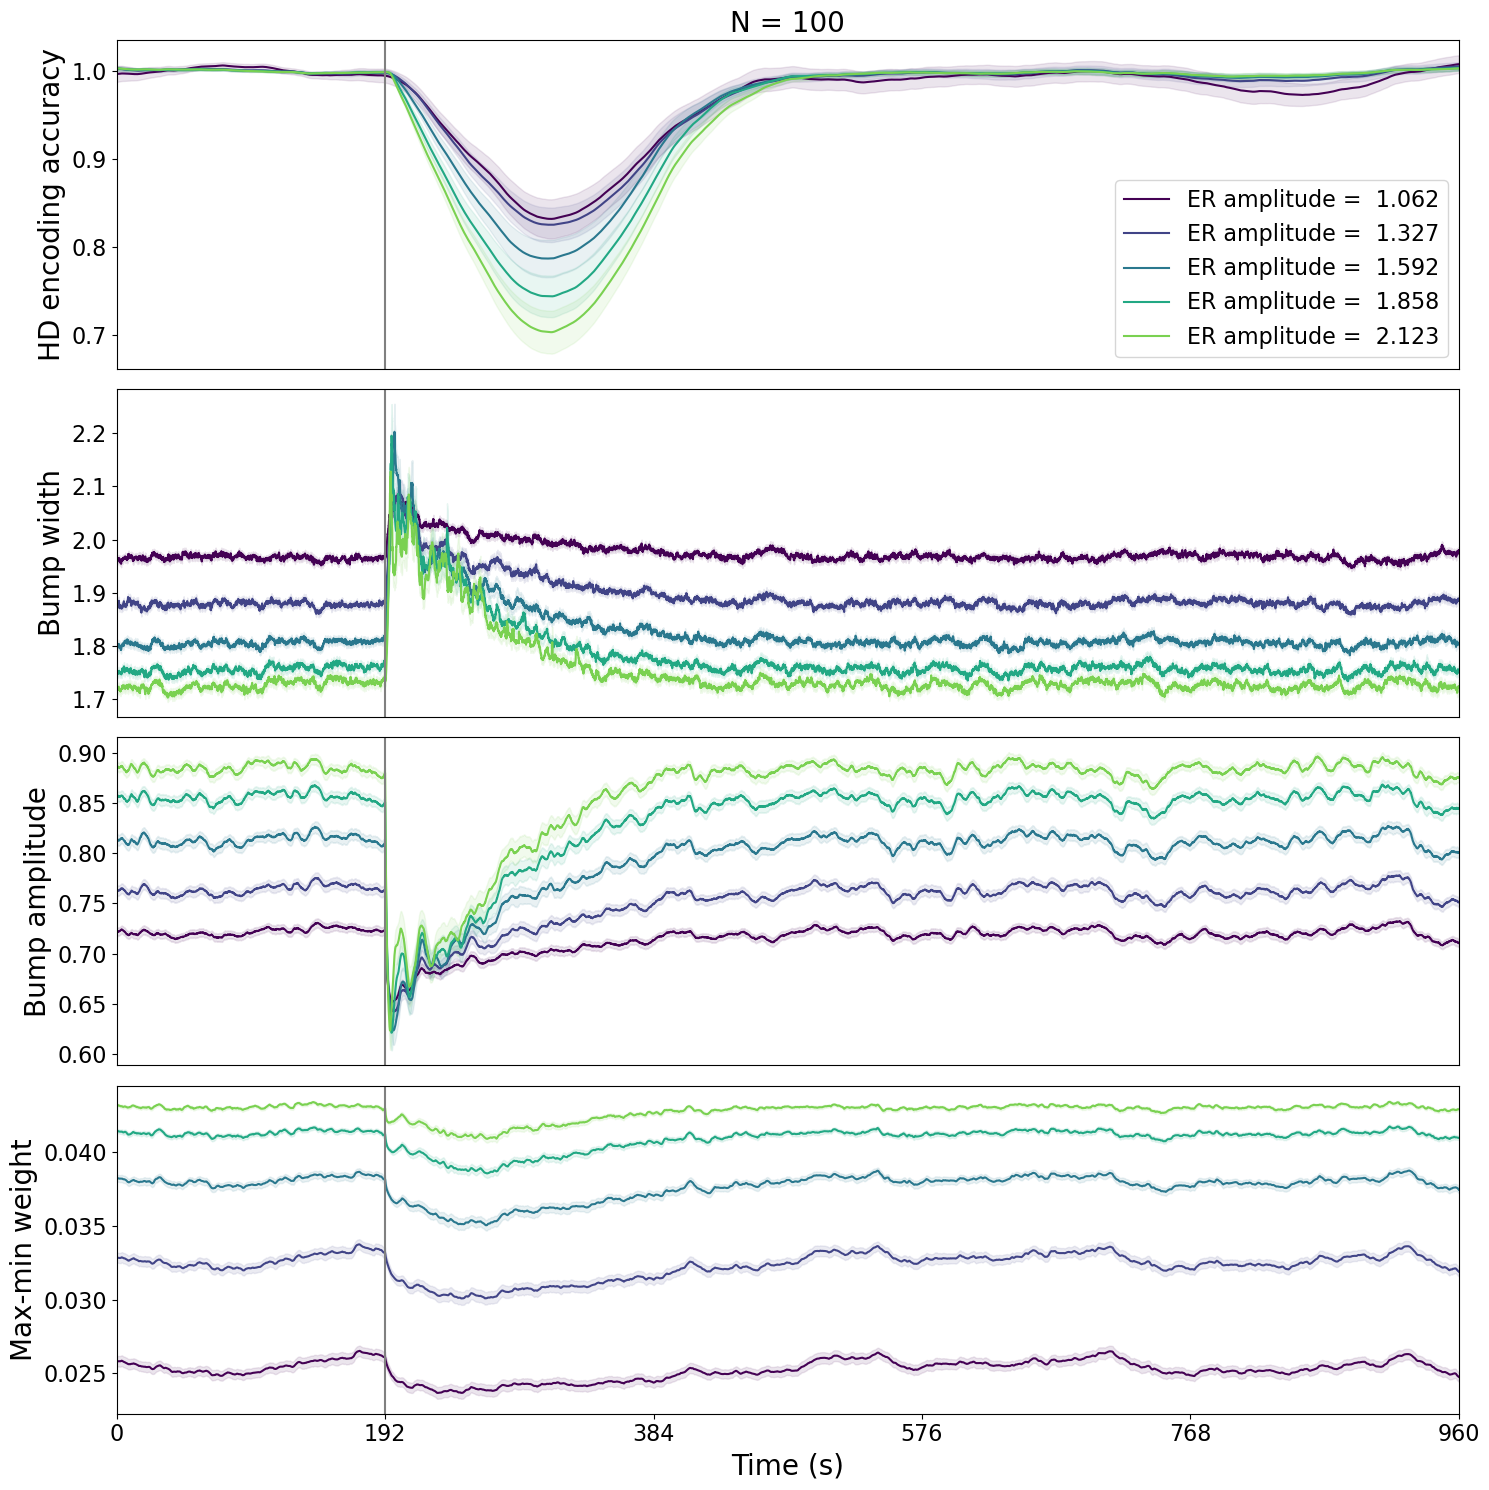

In [13]:
"""visualization - figure 7g"""

plot_fig7g = True

plot_normalized_HD_encoding_accuracy = True     # if True, plot normalized HD encoding accuracy vs. time
                                                # if False, plot (unnormalized) HD encoding accuracy vs. time

rescale_time_model2experiment = 24              # conversion factor to go from simulation time to real time

if plot_fig7g:
    """specify time axis tick marks and labels"""

    # array of tick locations along time axis
    xtick_locations = np.arange(0, T + T_gain_normal, T_gain_normal)

    # array of tick labels along time axis
    xtick_labels = xtick_locations * rescale_time_model2experiment  # convert from simulation time to real time


    """generate figure"""

    fig_7g, ax_7g = plt.subplots(4, 1, figsize=(15, 15))

    ax_7g[0].set_title(
        f'N = {n_sims}')

    for i_param, ER_amplitude in enumerate(ER_amplitude_array):
        color = plt.cm.viridis(i_param / n_params)

        if plot_normalized_HD_encoding_accuracy:
            # plot normalized HD encoding accuracy vs. time
            ax_7g[0].plot(np.arange(0, T, ra.dt), normalized_HD_encoding_accuracy_mean[i_param, :], \
                color=color, label=f'ER amplitude = {ER_amplitude : .03f}')
            ax_7g[0].fill_between(np.arange(0, T, ra.dt),
                normalized_HD_encoding_accuracy_mean[i_param, :] - normalized_HD_encoding_accuracy_sem[i_param, :], 
                normalized_HD_encoding_accuracy_mean[i_param, :] + normalized_HD_encoding_accuracy_sem[i_param, :],
                color=color, alpha=0.1
            )
        else:
            # plot (unnormalized) HD encoding accuracy vs. time
            ax_7g[0].plot(np.arange(0, T, ra.dt), HD_encoding_accuracy_mean[i_param, :], \
                color=color, label=f'ER amplitude = {ER_amplitude : .03f}')
            ax_7g[0].fill_between(np.arange(0, T, ra.dt),
                HD_encoding_accuracy_mean[i_param, :] - HD_encoding_accuracy_sem[i_param, :], 
                HD_encoding_accuracy_mean[i_param, :] + HD_encoding_accuracy_sem[i_param, :],
                color=color, alpha=0.1
            )

        # plot bump width vs. time
        ax_7g[1].plot(np.arange(0, T, ra.dt), bump_width_mean[i_param, :], color=color)
        ax_7g[1].fill_between(np.arange(0, T, ra.dt),
            bump_width_mean[i_param, :] - bump_width_sem[i_param, :], bump_width_mean[i_param, :] + bump_width_sem[i_param, :],
            color=color, alpha=0.1
        )

        # plot bump amplitude vs. time
        ax_7g[2].plot(np.arange(0, T, ra.dt), bump_amplitude_mean[i_param, :], color=color)
        ax_7g[2].fill_between(np.arange(0, T, ra.dt),
            bump_amplitude_mean[i_param, :] - bump_amplitude_sem[i_param, :], bump_amplitude_mean[i_param, :] + bump_amplitude_sem[i_param, :],
            color=color, alpha=0.1
        )

        # plot notch depth (max - min) vs. time
        ax_7g[3].plot(np.arange(0, T, ra.dt), W_notch_depth_mean[i_param, :], color=color)
        ax_7g[3].fill_between(np.arange(0, T, ra.dt),
            W_notch_depth_mean[i_param, :] - W_notch_depth_sem[i_param, :], W_notch_depth_mean[i_param, :] + W_notch_depth_sem[i_param, :],
            color=color, alpha=0.1
        )

    ax_7g[0].set_xlim([0, T])
    ax_7g[0].set_xticks([])
    ax_7g[0].axvline(t_gain_invert_start - T_burn_in, color='gray')
    ax_7g[0].set_ylabel('HD encoding accuracy')
    ax_7g[0].legend(loc='lower right')

    ax_7g[1].set_xlim([0, T])
    ax_7g[1].set_xticks([])
    ax_7g[1].axvline(t_gain_invert_start - T_burn_in, color='gray')
    ax_7g[1].set_ylabel('Bump width')

    ax_7g[2].set_xlim([0, T])
    ax_7g[2].set_xticks([])
    ax_7g[2].axvline(t_gain_invert_start - T_burn_in, color='gray')
    ax_7g[2].set_ylabel('Bump amplitude')

    ax_7g[3].set_xlim([0, T])
    ax_7g[3].set_xticks(xtick_locations)
    ax_7g[3].set_xticklabels(xtick_labels)
    ax_7g[3].axvline(t_gain_invert_start - T_burn_in, color='gray')
    ax_7g[3].set_xlabel('Time (s)')
    ax_7g[3].set_ylabel('Max-min weight')

    plt.tight_layout()

In [14]:
ER_amplitude_scale_array, ER_amplitude_array

(array([1.  , 1.25, 1.5 , 1.75, 2.  ]),
 array([1.06160234, 1.32700292, 1.59240351, 1.85780409, 2.12320468]))

In [15]:
"""example simulation run to show evolution of weight matrices"""

# if data file is available (and hence simulations were not re-run)
# then specify an ER amplitude scale and 
# run a single simulation to show the weight matrices at different time points
# if instead data file is unavailable and n_sims simulations were run
# then this cell is skipped and the last run from the simulations above is used and 
# take note of the ER amplitude (scale)

if have_data_file:

    # specify ER amplitude scale (cue intensity) as 'low', 'high', or numerical value
    ER_amplitude_scale = 'low'    # str ('low', 'high') or float

    if ER_amplitude_scale == 'low':
        ER_amplitude_scale = ER_amplitude_scale_array[0]
    elif ER_amplitude_scale == 'high':
        ER_amplitude_scale = ER_amplitude_scale_array[-1]
    else:
        pass

    ra.reset_network()

    # generate ground truth AV input and HD for learning
    v_AV, z_HD = generate_ground_truth(ra.dt, T_burn_in + T)

    # ground truth HD at the start of inverted gain learning
    z_invert_start = z_HD[int(t_gain_invert_start / ra.dt)]

    # ground truth AV during inverted gain learning, shape (n_timesteps_gain_invert,)
    v_AV_invert = v_AV[int(t_gain_invert_start / ra.dt):]

    # cue position during inverted gain learning, shape (n_timesteps_gain_invert,)
    cue_pos_invert = calc_invert_gain_cue_position(ra.dt, v_AV_invert, z_invert_start)

    # cue position during the entire simulation, excluding burn-in, shape (n_timesteps,)
    cue_pos = np.concatenate((z_HD[int(t_gain_normal_start):int(t_gain_invert_start / ra.dt)], cue_pos_invert), axis=0)

    # generate AV input noise
    noise_AV = generate_AV_input_noise(ra.dt, T_burn_in + T)

    # determine random initialization for weight matrix
    W_init = np.random.uniform(0, 1, (ra.N, ra.N))
    W_init = W_norm_init * W_init / np.linalg.norm(W_init)

    # generate ER input
    g_normal, g_invert, ER_amplitude = generate_ER_input(ra, T_burn_in + T, v_AV, z_HD, h_scale=ER_amplitude_scale)

    # concatenate first half of ER input for normal gain learning and second half of ER input for inverted gain learning
    g = np.vstack((g_normal[:int(t_gain_invert_start/ra.dt)], g_invert[-int(T_gain_invert/ra.dt):]))

    # generate ER input noise
    noise_g = generate_ER_input_noise(g)            # generate uniform input noise
    noise_g = noise_g.T / np.sum(noise_g, axis=1)   # normalize by sum, shape (ra.N, int(T/ra.dt))
    noise_g = ER_baseline * noise_g                 # scale by constant ER baseline, independent of ER activity
    noise_g = noise_g.T                             # shape (int(T/ra.dt), ra.N)

    # reset network
    ra.reset_network()

    # initialize weight matrix with random weights
    ra.W = np.copy(W_init)

    # simulate
    ra.simulate(T_burn_in + T, v = v_AV + noise_AV, g = g + noise_g, learn=True, trace=True)

    # output ER amplitude
    print(f'ER amplitude scale = {ER_amplitude_scale}\nER amplitude = {ER_amplitude}')

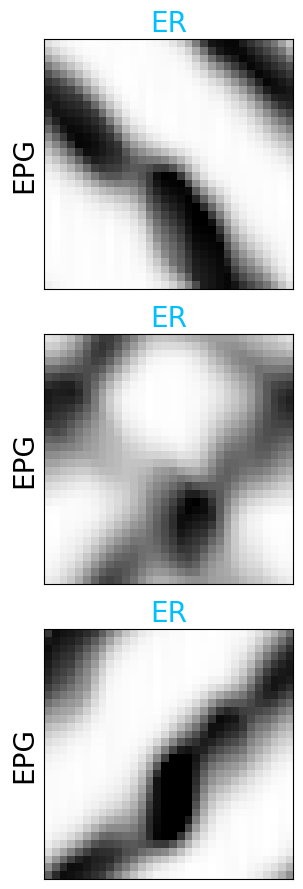

In [16]:
"""visualization - figure 7h"""

plot_fig7h = True

if plot_fig7h:
    fig7h_tstep1 = int(t_gain_invert_start / ra.dt) - 1
    fig7h_tstep2 = int((t_gain_invert_start + 2) / ra.dt)
    fig7h_tstep3 = int((t_gain_invert_start + T_gain_invert / 2) / ra.dt)

    fig_7h, ax_7h = plt.subplots(3, 1, figsize=(3, 9))

    # weight matrix prior to gain inversion
    im_normal_gain = ax_7h[0].imshow(
        ra.W_trace[fig7h_tstep1], aspect='equal', cmap='gray'
    )
    ax_7h[0].set_xticks([])
    ax_7h[0].set_yticks([])
    ax_7h[0].set_ylabel('EPG')
    ax_7h[0].set_title('ER', color='deepskyblue')

    # weight matrix during the initial part of the inverted gain epoch
    im_invert_gain_init = ax_7h[1].imshow(
        ra.W_trace[fig7h_tstep2], aspect='equal', cmap='gray'
    )
    ax_7h[1].set_xticks([])
    ax_7h[1].set_yticks([])
    ax_7h[1].set_ylabel('EPG')
    ax_7h[1].set_title('ER', color='deepskyblue')

    # weight matrix that has equilibrated in the later part of the inverted gain epoch
    im_invert_gain_equi = ax_7h[2].imshow(
        ra.W_trace[fig7h_tstep3], aspect='equal', cmap='gray'
    )
    ax_7h[2].set_xticks([])
    ax_7h[2].set_yticks([])
    ax_7h[2].set_ylabel('EPG')
    ax_7h[2].set_title('ER', color='deepskyblue')

    plt.tight_layout()

In [17]:
"""save figure"""

if save_fig7g:
    fig_7g.savefig(os.path.join(save2path, filename_fig7g + '.' + fig_format), format=fig_format)

if save_fig7h:
    fig_7h.savefig(os.path.join(save2path, filename_fig7h + '.' + fig_format), format=fig_format)